# Metrics in GPyTorch

In this notebook, we will see how to evaluate GPyTorch models with probabilistic metrics. 

**Note:** It is encouraged to check the Simple GP Regression notebook first if not done already. We'll reuse most of the code from there.

We'll be modeling the function

$$
\begin{align}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}
$$


In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In the next cell, we set up the train and test data.

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

test_x = torch.linspace(0, 1, 51)
test_y = torch.sin(test_x * (2 * math.pi)) + torch.randn(test_x.size()) * math.sqrt(0.04)

In the next cell, we define a simple GP regression model.

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Our model is ready for hyperparameter learning, but, first let us check how it performs on the test data.

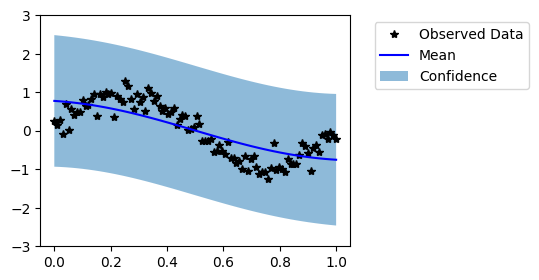

In [5]:
model.eval()
with torch.no_grad():
    untrained_pred_dist = likelihood(model(test_x))
    predictive_mean = untrained_pred_dist.mean
    lower, upper = untrained_pred_dist.confidence_region()
    
f, ax = plt.subplots(1, 1, figsize=(4, 3))
# Plot training data as black stars
ax.plot(train_x, train_y, 'k*')
# Plot predictive means as blue line
ax.plot(test_x, predictive_mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6,1));

Visually, this does not look like a good fit. Now, let us train the model hyperparameters.

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.914   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.882   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.848   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.811   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.770   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.725   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.678   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.629   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.583   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.540   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.501   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.464   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.429   lengthscale: 0.273   noise: 0.260
Iter 14/50 - Loss: 0.395   lengthscale: 0.258   noise: 0.237
Iter 15/50 - Loss: 0.361   lengthscale: 0.245   noise: 0.216
Iter 16/50 - Loss: 0.328   lengthscale: 0.236   noise: 0.197
Iter 17/50 - Loss: 0.294   length

In the next cell, we reevaluate the model on the test data.

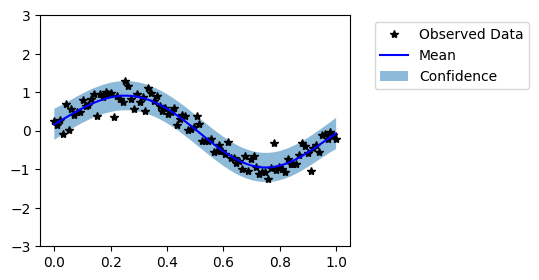

In [7]:
model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(test_x))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
    
f, ax = plt.subplots(1, 1, figsize=(4, 3))
# Plot training data as black stars
ax.plot(train_x, train_y, 'k*')
# Plot predictive means as blue line
ax.plot(test_x, predictive_mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6,1));

Now our model seems to fit well on the data. It is not always possible to visually evaluate the model in high dimensional cases. Thus, now we evaluate the models with help of probabilistic metrics. We have saved predictive distributions from untrained and trained models as `untrained_pred_dist` and `trained_pred_dist` respectively.

## Negative Log Predictive Density (NLPD)

Negative Log Predictive Density (NLPD) is the most standard probabilistic metric for evaluating GP models. In simple terms, it is negative log likelihood of the test data given the predictive distribution. It can be computed as follows:

In [10]:
init_nlpd = gpytorch.metrics.negative_log_predictive_density(untrained_pred_dist, test_y)
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, test_y)

print(f'Untrained model NLPD: {init_nlpd:.2f}, \nTrained model NLPD: {final_nlpd:.2f}')

Untrained model NLPD: 0.88, 
Trained model NLPD: -0.27


## Mean Standardized Log Loss (MSLL)

This metric computes average negative log likelihood of all test points w.r.t their univariate predicitve densities. For more details, see "page No. 23, Gaussian Processes for Machine Learning, Carl Edward Rasmussen and Christopher K. I. Williams, The MIT Press, 2006. ISBN 0-262-18253-X"

In [11]:
init_msll = gpytorch.metrics.mean_standardized_log_loss(untrained_pred_dist, test_y)
final_msll = gpytorch.metrics.mean_standardized_log_loss(trained_pred_dist, test_y)

print(f'Untrained model MSLL: {init_msll:.2f}, \nTrained model MSLL: {final_msll:.2f}')

Untrained model MSLL: 0.88, 
Trained model MSLL: -0.28


It is also possible to calculate the quantile coverage error with `gpytorch.metrics.quantile_coverage_error` function.

In [12]:
quantile = 95
qce = gpytorch.metrics.quantile_coverage_error(trained_pred_dist, test_y, quantile=quantile)
print(f'Quantile {quantile}% Coverage Error: {qce:.2f}')

Quantile 95% Coverage Error: 0.01


## Mean Squared Error (MSE)

Mean Squared Error (MSE) is the mean of the squared difference between the test observations and the predictive mean. It is a well-known conventional metric for evaluating regression models. However, it can not take uncertainty into account unlike NLPD, MLSS and ACE.

In [13]:
init_mse = gpytorch.metrics.mean_squared_error(untrained_pred_dist, test_y, squared=True)
final_mse = gpytorch.metrics.mean_squared_error(trained_pred_dist, test_y, squared=True)

print(f'Untrained model MSE: {init_mse:.2f}, \nTrained model MSE: {final_mse:.2f}')

Untrained model MSE: 0.19, 
Trained model MSE: 0.03


## Mean Absolute Error (MAE)

Mean Absolute Error (MAE) is the mean of the absolute difference between the test observations and the predictive mean. It is less sensitive to the outliers than MSE.

In [14]:
init_mae = gpytorch.metrics.mean_absolute_error(untrained_pred_dist, test_y)
final_mae = gpytorch.metrics.mean_absolute_error(trained_pred_dist, test_y)

print(f'Untrained model MAE: {init_mae:.2f}, \nTrained model MAE: {final_mae:.2f}')

Untrained model MAE: 0.39, 
Trained model MAE: 0.14
